In [1]:
import os, inspect, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

CURRENT_DIR = os.path.dirname(inspect.getabsfile(inspect.currentframe()))
ROOT_DIR = os.path.dirname(CURRENT_DIR)
sys.path.insert(0, ROOT_DIR)

from reb.src.pyts import series_to_supervised

Using TensorFlow backend.


In [2]:
ffname = os.path.join(ROOT_DIR, "reb", "data", "ext", "data_monthly_processed.csv")

In [3]:
df = pd.read_csv(ffname, parse_dates=["DATE"])
df.DATE = pd.to_datetime(df.DATE, format="%Y-%m")
df.head()


,DATE,PAYEMS,USPRIV,AWHNONAG,CES9091000001,USGOVT,UNEMPLOY,LNS13023622,LNS13023706,LNS13023654,LNS13026511,MVPHGFD027MNFRBDAL,MORTGAGE30US,MORTGAGE15US,DGS10,INDPRO,W875RX1
0,1992-01-01,108374,89686,34.1,3137,18688,9283,54.0,11.9,13.1,40.9,2719.3,8.4,8.0,7.0,63.3372,6840.9
1,1992-02-01,108317,89628,34.1,3121,18689,9454,57.0,9.8,13.6,43.3,2738.8,8.8,8.4,7.3,63.7864,6879.1
2,1992-03-01,108369,89654,34.1,3121,18715,9460,57.4,9.5,13.4,44.0,2760.5,8.9,8.6,7.5,64.3199,6884.7
3,1992-04-01,108526,89787,34.3,3117,18739,9415,57.3,10.4,13.6,43.8,2764.0,8.9,8.5,7.5,64.8069,6903.6
4,1992-05-01,108653,89900,34.3,3119,18753,9744,57.7,10.3,12.8,44.9,2830.7,8.7,8.3,7.4,65.0202,6941.7


Make a clen copy of data. This allows us to modify freely while we have always the original data for any further reference.

In [4]:
df_original = df.copy() 

Reindex data frame per the time stamps

In [5]:
df.set_index("DATE", inplace=True)
df.head()

,PAYEMS,USPRIV,AWHNONAG,CES9091000001,USGOVT,UNEMPLOY,LNS13023622,LNS13023706,LNS13023654,LNS13026511,MVPHGFD027MNFRBDAL,MORTGAGE30US,MORTGAGE15US,DGS10,INDPRO,W875RX1
DATE,,,,,,,,,,,,,,,,
1992-01-01,108374,89686,34.1,3137,18688,9283,54.0,11.9,13.1,40.9,2719.3,8.4,8.0,7.0,63.3372,6840.9
1992-02-01,108317,89628,34.1,3121,18689,9454,57.0,9.8,13.6,43.3,2738.8,8.8,8.4,7.3,63.7864,6879.1
1992-03-01,108369,89654,34.1,3121,18715,9460,57.4,9.5,13.4,44.0,2760.5,8.9,8.6,7.5,64.3199,6884.7
1992-04-01,108526,89787,34.3,3117,18739,9415,57.3,10.4,13.6,43.8,2764.0,8.9,8.5,7.5,64.8069,6903.6
1992-05-01,108653,89900,34.3,3119,18753,9744,57.7,10.3,12.8,44.9,2830.7,8.7,8.3,7.4,65.0202,6941.7


In [6]:
# rescale data
values = df.values
values = values.astype("float32")
scaler = MinMaxScaler(feature_range=(0, 1))
values_scaled = scaler.fit_transform(values)
n_variables = values.shape[1]

In [7]:
index_target = 15
# set model parameters
n_lags = 6
n_sequences = 6
n_train = int(values.shape[0] * 0.8)
n_units = 40

In [25]:
# set train parameters
optimizer = "adam"
loss = "mse"
n_epochs = 20
sz_batch = 10
verbose = 1


In [26]:
df_reframed = series_to_supervised(values_scaled, n_lags, n_sequences)
df_reframed.head()
# [print(elem) for elem in df_reframed.columns]

var1(t-6)  var2(t-6)  var3(t-6)  var4(t-6)  var5(t-6)  var6(t-6)  \
6    0.000000   0.000000   0.894735   0.472574   0.001510   0.244251   
7    0.004774   0.005566   1.000000   0.478200   0.000000   0.241516   
8    0.009898   0.010669   0.894735   0.489451   0.004698   0.241212   
9    0.016853   0.017436   0.894735   0.490858   0.012248   0.208793   
10   0.021504   0.022586   0.947367   0.497890   0.012752   0.212035   

    var7(t-6)  var8(t-6)  var9(t-6)  var10(t-6)     ...      var4(t+5)  \
6    0.324675   0.470085   0.569892    0.357401     ...       0.565401   
7    0.272727   0.649573   0.473118    0.350181     ...       0.563994   
8    0.259740   0.606838   0.462366    0.342960     ...       0.555556   
9    0.294372   0.606838   0.494624    0.361011     ...       0.547117   
10   0.233766   0.598291   0.451613    0.324910     ...       0.538678   

    var5(t+5)  var6(t+5)  var7(t+5)  var8(t+5)  var9(t+5)  var10(t+5)  \
6    0.052181   0.147401   0.142857   0.683761   0.440860    0.252708   
7    0.055201   0.149124   0.129870   0.803419   0.451613    0.238267   
8    0.059228   0.146692   0.155844   0.717949   0.473118    0.249097   
9    0.068960   0.141323   0.134199   0.871795   0.473118    0.238267   
10   0.069799   0.113464   0.069264   0.811966   0.451613    0.187726   

    var11(t+5)  var12(t+5)  var13(t+5)  
6     0.007567      0.9125      0.9375  
7     0.011244      0.8875      0.9000  
8     0.013499      0.8250      0.8375  
9     0.012810      0.8250      0.8625  
10    0.010095      0.8625      0.9000  

[5 rows x 156 columns]

In [27]:
# create train/valid data
# split into train and test sets
values = df_reframed.values
train_values, valid_values = values[:n_train, :], values[n_train:, :]
print(f"Train Inputs Shape: {train_values.shape}")
print(f"Valid Inputs Shape: {valid_values.shape}")

Train Inputs Shape: (256, 192)
Valid Inputs Shape: (53, 192)


In [28]:
# split into input and targets
n_train, n_ = train_values.shape
n_valid, n_ = valid_values.shape
n_features = n_lags * n_variables


In [29]:
# split into input and targets
n_train, n_ = train_values.shape
n_valid, n_ = valid_values.shape
n_features = n_lags * n_variables


In [17]:
# split into input and targets
n_train, n_ = train_values.shape
n_valid, n_ = valid_values.shape
n_observations = n_lags * n_variables
x_train, y_train = train_values[:, :n_observations], train_values[:, n_observations+index_target:n_:n_variables]
x_valid, y_valid = valid_values[:, :n_observations], valid_values[:, n_observations+index_target:n_:n_variables]
print(f"Train Inputs Shape: {x_train.shape}, Train Targets Shape: {y_train.shape}")
print(f"Valid Inputs Shape: {x_valid.shape}, Valid Targets Shape: {y_valid.shape}")

Train Inputs Shape: (304, 78), Train Targets Shape: (304, 6)
Valid Inputs Shape: (65, 78), Valid Targets Shape: (65, 6)


In [18]:
# reshape data as required by ltsm
x_train = x_train.reshape((n_train, n_lags, n_variables))
x_valid = x_valid.reshape((n_valid, n_lags, n_variables))
print(f"Train Inputs Shape: {x_train.shape}, Train Targets Shape: {y_train.shape}")
print(f"Valid Inputs Shape: {x_valid.shape}, Valid Targets Shape: {y_valid.shape}")

Train Inputs Shape: (304, 6, 13), Train Targets Shape: (304, 6)
Valid Inputs Shape: (65, 6, 13), Valid Targets Shape: (65, 6)


In [19]:
# build model
model = Sequential()
model.add(LSTM(n_units, input_shape=(n_lags, n_variables)))
model.add(Dense(n_sequences))
model.compile(loss=loss, optimizer=optimizer)

In [20]:
# train model
history = model.fit(x_train, y_train,
                    epochs=n_epochs,
                    batch_size=sz_batch,
                    validation_data=(x_valid, y_valid),
                    verbose=verbose,
                    shuffle=False)

Train on 304 samples, validate on 65 samples
Epoch 1/20
304/304 [==============================] - 2s 6ms/step - loss: 0.1064 - val_loss: 0.0618
Epoch 2/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0782 - val_loss: 0.0470
Epoch 3/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0264 - val_loss: 0.0111
Epoch 4/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0088 - val_loss: 0.0055
Epoch 5/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 0.0042
Epoch 6/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0019 - val_loss: 0.0033
Epoch 7/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0033
Epoch 8/20
304/304 [==============================] - 1s 2ms/step - loss: 0.0011 - val_loss: 0.0039
Epoch 9/20
304/304 [==============================] - 1s 2ms/step - loss: 9.4831e-04 - val_loss: 0.0042
Epoch 10/20
304/304 [==============================

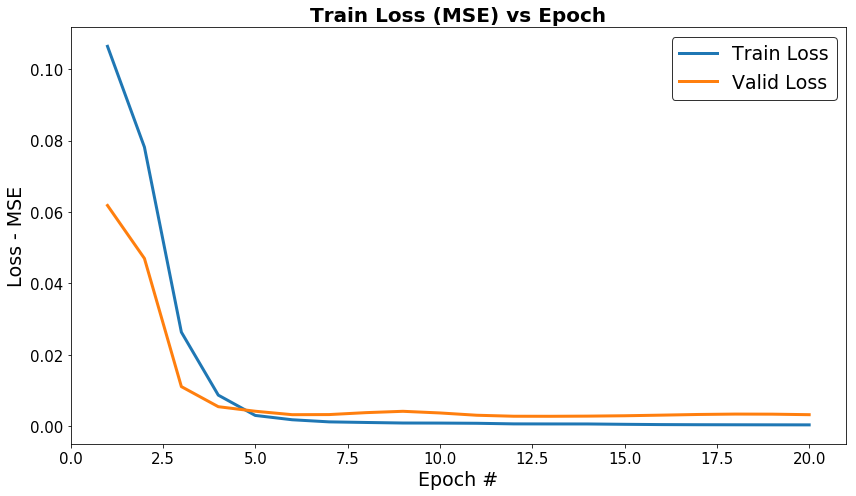

In [21]:
# plot history
figsize = (12, 7)
titlefontsize = 20
xtickfontsize = 15
ytickfontsize = 15
labelfontsize = 19
legendfontsize = 19
linewidth = 3
fig = plt.figure(figsize=figsize)
ax = fig.subplots(1, 1)
ax.plot(np.arange(1, n_epochs+1), history.history['loss'],
        "-",
        linewidth=linewidth,
        label='Train Loss')
ax.plot(np.arange(1, n_epochs+1), history.history['val_loss'],
        "-",
        linewidth=linewidth,
        label='Valid Loss')
ax.set_xlabel("Epoch #", fontsize=labelfontsize)
ax.set_ylabel("Loss - " + loss.upper(), fontsize=labelfontsize)
ax.tick_params(
    axis='x',          
    which='both',      
    labelsize=xtickfontsize)
ax.tick_params(
    axis='y',    
    labelsize=ytickfontsize)
ax.set_title("Train Loss " +  f"({loss})".upper() + " vs Epoch",
        fontsize=titlefontsize,
        fontweight="bold"
    )
ax.legend(loc="upper right",
          fontsize=legendfontsize,
          framealpha=0.8,
          fancybox=True,
          frameon=True,
          shadow=False,
          edgecolor="k")
ax.set_xlim([0, n_epochs+1])
plt.tight_layout()
fname = f"loss-plot-valid.png"
# fig.savefig(os.path.join(ROOT_DIR, "reports", "figures", fname), transparent=False, dpi=dpi)
plt.show()

In [22]:
# make a prediction
yhat_valid = model.predict(x_valid)

In [23]:
temp = x_valid.reshape((n_valid, n_lags*n_variables))
temp[-n_sequences*n_variables:][:, index_target:n_sequences*n_variables:n_variables] = \
    y_valid.reshape((n_valid, n_sequences))
temp = temp.reshape((-1, n_variables))
y_valid = scaler.inverse_transform(temp)[:, index_target]

temp = x_valid.reshape((n_valid, n_lags*n_variables))
temp[-n_sequences*n_variables:][:, index_target:n_sequences*n_variables:n_variables] = \
    yhat_valid.reshape((n_valid, n_sequences))
temp = temp.reshape((-1, n_variables))
yhat_valid = scaler.inverse_transform(temp)[:, index_target]

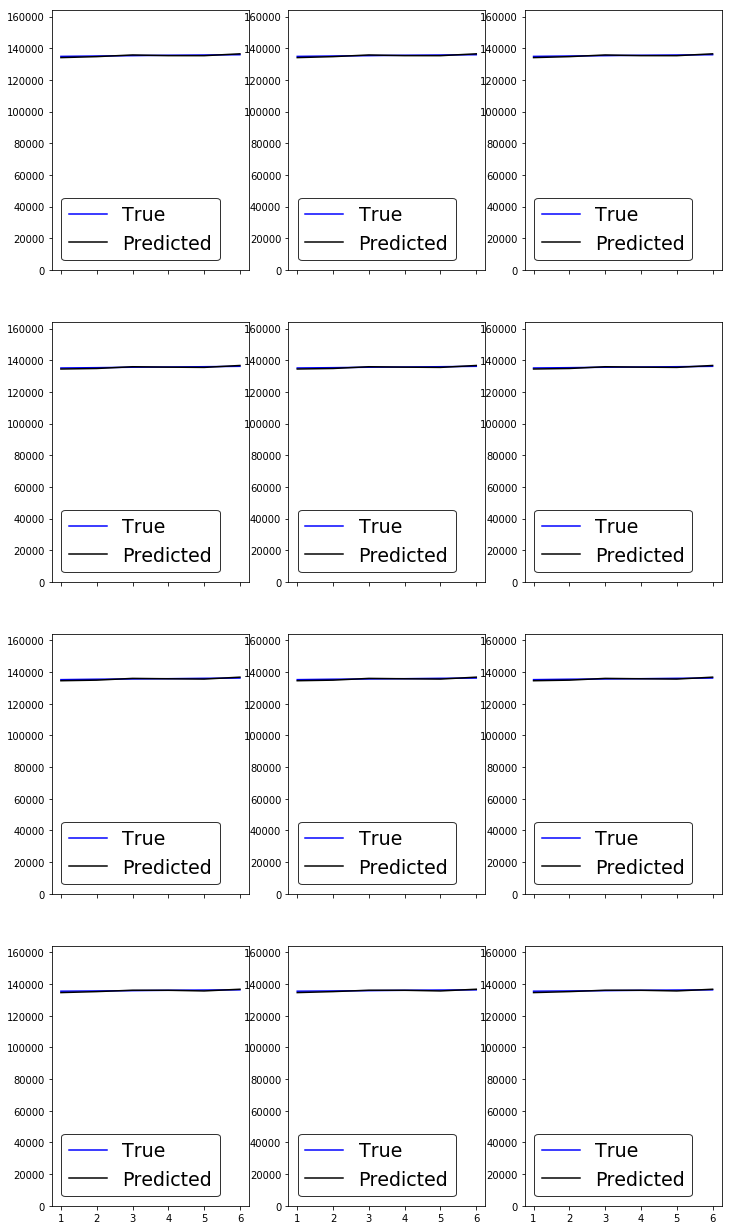

In [24]:
n = 12
ncols = 3
fig, axs = plt.subplots(nrows=int(np.ceil(n/ncols)),
                        ncols=ncols,
                        figsize=(12, 22),
                        sharex=True)
for k in range(n):
    i = k // ncols
    j = k % ncols
    axs[i, j].plot(np.arange(1,n_sequences+1),
                   y_valid[i*n_sequences:i*n_sequences+n_sequences],
                   color="blue",
                   label="True")
    axs[i, j].plot(np.arange(1,n_sequences+1),
                   yhat_valid[i*n_sequences:i*n_sequences+n_sequences],
                   color="black",
                   label="Predicted")
    
    
    axs[i, j].legend(loc="best",
                     fontsize=legendfontsize,
                     framealpha=0.8,
                     fancybox=True,
                     frameon=True,
                     shadow=False,
                     edgecolor="k")
    
    axs[i, j].set_ylim([0, 1.1*max(y_valid)])
#     print(y_valid[i*n_sequences:i*n_sequences+n_sequences].shape) 
    